In [3]:
from compute import Var, Par
from datastructures.api import Model, adda, addf, addsolver, setsolvefor, evalexpr, edges_no_param, addobj, addineq, OPT, SolverRef
from datastructures.execution import edges_from_components
from datastructures.graphutils import (namefromsympy, dfs_tree, SOLVER, VAR, COMP, nested_sources, 
sources, edges_to_Ein_Eout, flat_graph_formulation, root_solver, namefromid, copy_dicts, all_variables, all_edges)
from datastructures.nestedgraph import root_sources, build_typedgraph
from datastructures.workflow import get_f, order_from_tree, default_solver_options, mdao_workflow
from datastructures.workflow_mdao import mdao_workflow_with_args
from datastructures.operators import sort_scc, reorder_merge_solve
from datastructures.assembly import build_archi
from datastructures.runpipeline import model_to_problem
from datastructures.postprocess import print_inputs, print_outputs
from datastructures.rendering import render_incidence
from datastructures.tearing import dir_graph, min_arc_set_assign, min_arc_set, min_max_scc, min_max_scc2
from datastructures.transformations import transform_components
from collections import OrderedDict
import matplotlib.pyplot as plt
from sympy import cos, pi, log, sqrt
import openmdao.api as om
import networkx as nx
from itertools import chain

In [4]:
#from pearl_initial_formulation import *

## Variables

In [5]:
Df = Var('D_f', 2, unit='m')
Ds = Var('D_s', 1, unit='m')
Dd = Var('D_d', 1.25, unit='m')
tf = Var('t_f', 0.5, unit='m')
ts = Var('t_s', 2, unit='m')
td = Var('t_d', 0.5, unit='m')

## Parameters

In [6]:
rhow = Par(r'\rho_w', 1023.6, 'kg/m^3') # density of seawater [kg/m^3]
rho = Par(r'\rho', 700, 'kg/m^3')       # arbitrarily set
rhoh = Par(r'\rho_h', 2700, 'kg/m^3')   # arbitrarily set

In [7]:
idbyname = True
model = Model(rootname='root')
m = model.root
#m = addsolver(model.root, name='mdf', idbyname=idbyname)

## Geometry

In [8]:
geometry = m#addsolver(m, name='geometry', idbyname=idbyname)

In [9]:
A_s = Var('A_{solar}', unit='m^2')
alpha = Par(r'\alpha', 0.05)
adda(geometry, Df, (4*abs(A_s)/(pi*(1-alpha)))**0.5)
d = adda(geometry, 'd', alpha*Df)

## Hydrodynamics

In [10]:
hydro = m#addsolver(m, name='hydro', idbyname=idbyname)

In [11]:
hf = Var('h_f', 0.9*tf.varval, 'm')
g = Par('g', 9.81, 'm/s^2')

In [12]:
Vd = adda(hydro, 'Vd', pi/4*(Df**2*hf+Ds**2*ts+Dd**2*td))

In [13]:
FB = adda(hydro, 'F_B', rhow*Vd*g, unit='N')
FW = adda(hydro, 'F_W', FB)

In [14]:
#hf = adda(hydro, 'h_f', (4*Vd/pi-Ds**2*ts-Dd**2*td)/Df**2)

In [15]:
xd = td/2
xs = td+ts/2
xf1 = td+ts+hf/2
xf2 = td+ts+tf/2
totA1 = hf*Df+ts*Ds+td*Dd
totA2 = tf*Df+ts*Ds+td*Dd

In [16]:
KB = adda(hydro, 'K_B', (hf*Df*xf1+ts*Ds*xs+td*Dd*xd)/totA1) # z_B
KG = adda(hydro, 'K_G', (tf*Df*xf2+ts*Ds*xs+td*Dd*xd)/totA2) 
I = adda(hydro, 'I', pi/64*Df**4)
BM = adda(hydro, 'B_M', I/Vd)
#should be 3-5% according to http://web.mit.edu/13.012/www/handouts/Reading3.pdf
GM = adda(hydro, 'G_M', KB+BM-KG) 

In [17]:
mtot = Var('m_{platform}', unit='kg')

In [18]:
C33 = adda(hydro, 'C_{33}', pi*rhow*g/4*Df**2)
A33 = adda(hydro, 'A_{33}', 0.0525*pi*rhow*(Dd**3+Ds**3+Df**3))
omega0 = adda(hydro, r'\omega_0', (C33/(A33+mtot))**1/2, unit='rad/s', forceunit=True)

## Mass

In [19]:
mass = m#addsolver(m, name='mass', idbyname=idbyname)

In [20]:
adda(mass, mtot, FW/g, 'kg')
mbatt = Var('m_{batt}', unit='kg')
mprop = Par('m_{prop}', 50, 'kg') # mass of propulsion
mcomms = Par('m_{comms}', 50, 'kg') # mass of comms system
eta_solar = Par(r'\eta_{solar}', 10, 'kg/m^2')
msolar = adda(mass, 'm_{solar}', eta_solar*A_s)
mstruct = adda(mass, 'm_{struct}', mtot-mbatt-msolar-mcomms-mprop) 
adda(mass, td, (4/pi*mstruct-Df**2*tf*rho-Ds**2*ts*rho)/(Dd**2*rhoh))

t_d

## Propulsion

In [21]:
prop = m#addsolver(m, name='prop', idbyname=idbyname)

In [22]:
S_wd = pi*((Dd/2)**2-(Ds/2)**2+(Dd/2)**2+2*(Dd/2)*td)
S_ws = 2*pi*(Ds/2)*ts
S_wf = pi*((Df/2)**2-(Ds/2)**2+2*(Df/2)*hf)
S_w = adda(prop, 'S_w', S_wd+S_ws+S_wf, 'm**2') # wetted surface
C_d = Par('C_d', 1) # estimate drag coefficient (a square flat plate at 90 deg to the flow is 1.17)
v = Var('v', 1, unit='m/s') # [m/s]
eta_m = Par(r'\eta_m', 0.75) # estimated, need to determine from motors?
# D = rhow*C_d*S_w*v**2*0.5
P_move = adda(prop, 'P_{move}', rhow*C_d*S_w*v**3/(2*eta_m), unit='W')

## Communications

In [23]:
comms = m#addsolver(m, name='comms', idbyname=idbyname)

In [24]:
db2dec = lambda x: 10**(x/10)
dec2db = lambda x: 10*log(abs(x), 10)

In [25]:
k = Par('k', 1.38065e-23, 'J/K')
c = Par('c', 3e8, 'm/s')
f = Par('f', 2.2, 'GHz')

In [26]:
Lambda = adda(comms, r'\lambda', c/f, unit='m')

In [27]:
eta_parab = Par(r'\eta_{parab}', 0.55)
theta_t = Par(r'\theta_t', 32)
error_t = Par('e_t', 27)

In [28]:
#G_pt_db = adda(comms, 'G_{pt}', 44.3-dec2db(theta_t**2), forceunit=True)
L_pt_db = adda(comms, 'L_{pt}', -12*(error_t/theta_t)**2)
#G_t = adda(comms, 'G_t', db2dec(G_pt_db+L_pt_db))

In [29]:
G_t = adda(comms, 'G_t', eta_parab*(pi*d/Lambda)**2)

In [30]:
D_r = Par('D_r', 0.3, 'm')
G_r = adda(comms, 'G_r', eta_parab*(pi*D_r/Lambda)**2)

In [31]:
h = Par('h', 780, 'km')
Re = Par('Re', 6378, 'km')
S = adda(comms, 'S', sqrt(h*(h+2*Re)), unit='km', forceunit=True)

In [32]:
L_s = adda(comms, 'L_s', (Lambda/(4*pi*S))**2)

In [33]:
BER = Par('BER', 0.0001)
R = Var('R', 10, 'Mbit/s') # 1 per microseconds
T_s = Par('T_s', 135, 'K')
L_a = Par('L_a', db2dec(-0.3))
L_l = Par('L_l', db2dec(-1))
L_p = Par('L_p', db2dec(-0.1))
EN = Var('EN', 10)
Pcomms = adda(comms, 'P_{comms}', EN/(L_a*L_s*L_l*L_p*G_r*G_t)*(k*T_s*R), unit='W')

## Power

In [34]:
power = m#addsolver(m, name='power', idbyname=idbyname)

### Energy budget

In [35]:
# should t_move, t_comms, t_service and t_recharge add up to 24 hours?
t_mission = Par('t_{mission}', 24, 'hr')
t_comms = Par('t_{comms}', 1, 'hr')
t_move = Par('t_{move}', 1, 'hr')
t_service = Par('t_{service}', 12, 'hr')
t_recharge = Par('t_{recharge}', 12, 'hr')

In [36]:
P_hotel = Par('P_{hotel}', 50, 'W')
E_AUV = Par('E_{AUV}', 1.9, 'kW*hr') # AUV battery capacity (to be recharged), based on Bluefin-9
gamma = Par(r'\gamma', 1) # AUVs serviced per mission duration (aka in the time of t_mission)

In [37]:
E_move = adda(power, 'E_{move}', P_move*t_move, unit='kW*hr')
E_hotel = adda(power, 'E_{hotel}', P_hotel*t_mission, unit='kW*hr')
E_comms = adda(power, 'E_{comms}', Pcomms*t_comms, unit='W*hr')
E_service = adda(power, 'E_{service}', E_AUV * gamma, unit='kW*hr')
P_service = adda(power, 'P_{service}', E_service/t_service, unit='W')

In [38]:
E_required = adda(power, 'E_{required}', E_hotel+E_move+E_service+E_comms, unit='kW*hr')

### Solar panel sizing

In [39]:
E_recharge = adda(power, 'E_{recharge}', E_required, unit='kW*hr')
P_recharge = adda(power, 'P_{recharge}', E_recharge / t_recharge, unit='W')

In [40]:
eta_s = Par(r'\eta_s', 0.27)
phi_s = Par(r'\phi_s', 800, 'W/m**2')
theta_bar = Par(r'\theta', 55, 'deg')
Ideg = Par('I_{deg}', 0.9)
ddeg = Par('d_{deg}', 0.005)
Lsolar = Par('L_{solar}', 10) #lifetime in years, but units act weirdly in powers

In [41]:
adda(power, A_s, P_recharge / (eta_s * phi_s * cos(theta_bar) * Ideg * (1-ddeg)**Lsolar), unit='m^2', forceunit=True)

A_{solar}

### Battery sizing

In [42]:
mu_batt = Par(r'\mu_{battery}', 200, 'W*hr/kg') # Lithium ion
DOD = Par('DOD', 0.7)
eta_batt = Par(r'\eta_{battery}', 0.85) # transmission efficiency
#nu_batt = Par(r'\nu_{battery}', 450, 'kW*hr/(m**3)')
N = Par('N', 1)
C = adda(power, 'C', E_required/(DOD*N*eta_batt), unit='kW*hr')
#V_batt = adda(power, 'V_{batt}', C/nu_batt, unit='m**3')
m_batt_zero = Par('m_{batt_zero}', 5, 'kg')
adda(power, mbatt, C/mu_batt + m_batt_zero, unit='kg') # was already defined in the beginning

m_{batt}

# Visualize model

In [43]:
nodetyperepr = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
edges, tree = model.generate_formulation()
edges_nopar = edges_no_param(model, edges) # filter out variables that are parameters

In [44]:
nodetyperepr_hsm = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
namingfunc_hsm = namefromid(nodetyperepr_hsm)

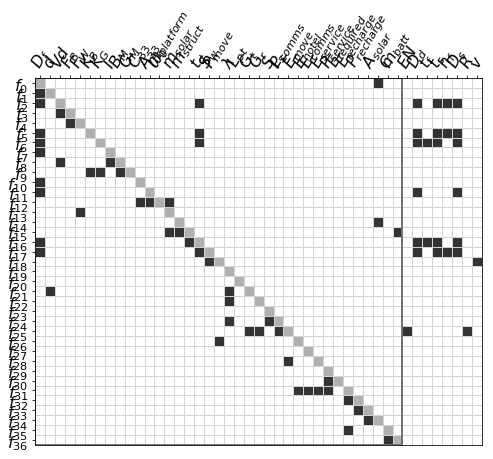

In [45]:
_, ax = render_incidence(edges_nopar, tree, namingfunc_hsm, figsize=(8,8), figname="pearl_default_hsm.png", save=False)

# Analysis of initial formulation

In [46]:
opt = SolverRef('opt', model, 'opt')
addobj(opt, mtot) # for optimization make sure to add OPT in model
addineq(opt, -td)
addineq(opt, hf-0.9*tf)
addineq(opt, Ds-0.9*Df)
addineq(opt, Ds-0.9*Dd)
addineq(opt, Ds-0.9*Dd)
addineq(opt, 0.1-P_move)
solvefor = [tf, ts, Ds, Dd, hf]
varoptions = {tf:[0,10], ts:[0,10], Ds:[0,10], Dd:[0,10], hf:[0,10]}

In [47]:
edges, tree = model.generate_formulation()

In [48]:
tree = (tree[0], {'root':'opt'}, {elt.varid:'opt' for elt in solvefor})
model.var_options = {elt.varid:var for elt,var in varoptions.items()}

In [55]:
solvers_options = model.solvers_options
#solvers_options['mdf'] = {'solver': 'N', 'maxiter':20}
solvers_options['root'] = {'solver': 'N', 'maxiter':20}
solvers_options['opt'] = {'type': OPT, 'optimizer': 'IPOPT', 'driver': om.pyOptSparseDriver}
nodetyperepr = model.nametyperepr
nodetyperepr[SOLVER] = '{}'

In [56]:
#edges, tree = model.generate_formulation()
comp_options = model.comp_options
var_options = model.var_options
solvers_options = model.solvers_options
components = model.components
idmapping = model.idmapping # map from str to Var
nodetyperepr = model.nametyperepr
sequence = order_from_tree(tree[0], tree[1], edges[1])
solvers_options = default_solver_options(tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [57]:
prob, mdao_in, groups, namingfunc = model_to_problem(model, formulation=(edges, tree))

In [58]:
# prob.set_solver_print(level=0)
# prob.set_solver_print(level=1, depth=1)
# prob.setup();

In [59]:
prob.set_val('alpha', 0.2)
prob.set_val('t_f',0.15)
prob.set_val('t_s',0.2)
prob.set_val('t_d',0.2)
prob.set_val('D_f', 3.713)
prob.set_val('D_s', 0.1)
prob.set_val('D_d', 1.)
prob.set_val('P_comms', 50)

In [60]:
prob.run_driver()

/home/johan/miniconda3/envs/pyoptsparse/lib/python3.9/site-packages/pyoptsparse/pyOpt_optimization.py:234: UserWarning: The argument `type=` is deprecated. Use `varType` in the future.
  warnings.warn("The argument `type=` is deprecated. Use `varType` in the future.")



====
root
====
NL: NewtonSolver 'NL: Newton' on system 'root' failed to converge in 20 iterations.

====
root
====
NL: NewtonSolver 'NL: Newton' on system 'root' failed to converge in 20 iterations.

====
root
====
NL: NewtonSolver 'NL: Newton' on system 'root' failed to converge in 20 iterations.

====
root
====
NL: NewtonSolver 'NL: Newton' on system 'root' failed to converge in 20 iterations.

====
root
====
NL: NewtonSolver 'NL: Newton' on system 'root' failed to converge in 20 iterations.

====
root
====
NL: NewtonSolver 'NL: Newton' on system 'root' failed to converge in 20 iterations.

====
root
====
NL: NewtonSolver 'NL: Newton' on system 'root' failed to converge in 20 iterations.

====
root
====
NL: NewtonSolver 'NL: Newton' on system 'root' failed to converge in 20 iterations.

====
root
====
NL: NewtonSolver 'NL: Newton' on system 'root' failed to converge in 20 iterations.

====
root
====
NL: Newton Converged in 5 iterations

====
root
====
NL: Newton Converged in 4 itera

False

In [61]:
print_outputs(model, prob, namingfunc, rounding=3)

$$D_f$$,4.662,m
$$d$$,0.932,m
$$Vd$$,1.198,m³
$$F_B$$,1.203×10⁴,N
$$F_W$$,1.203×10⁴,kg·m/s²
$$K_B$$,0.219,m
$$K_G$$,0.219,m
$$I$$,23.195,m⁴
$$B_M$$,19.363,m
$$G_M$$,19.363,m
$$C_{33}$$,1.714×10⁵,kg/s²


In [52]:
#print_inputs(model, prob, namingfunc, mdao_in)

In [53]:
prob.set_val('D_s', 0.1)
prob.set_val('t_s', 0.2)
prob.set_val('D_d', 1)
tfval = 0.15
prob.set_val('t_f', tfval)
prob.set_val('h_f', 0.9*tfval)
prob.set_val('rho', 600)

In [54]:
prob.run_model()


====
root
====
NL: Newton Converged in 5 iterations


In [81]:
prob.get_val('t_d')

array([0.15521238])

In [82]:
print_inputs(model, prob, namingfunc, mdao_in)

$$D_s$$,0.1,m
$$t_s$$,0.2,m
$$t_f$$,0.15,m
$$R$$,10,Mbit/s
$$h_f$$,0.135,m
$$D_d$$,1,m
$$EN$$,10,
$$v$$,1,m/s


In [83]:
print_outputs(model, prob, namingfunc, rounding=3)

$$D_f$$,3.712,m
$$d$$,0.186,m
$$Vd$$,1.584,m³
$$F_B$$,1.591×10⁴,N
$$F_W$$,1.591×10⁴,kg·m/s²
$$K_B$$,0.339,m
$$K_G$$,0.351,m
$$I$$,9.319,m⁴
$$B_M$$,5.882,m
$$G_M$$,5.87,m
$$C_{33}$$,1.087×10⁵,kg/s²


## Graph of partitions (level 1) 

In [58]:
from representations import draw

In [59]:
Ein_nopar, Eout_nopar = edges_to_Ein_Eout(edges_nopar)

In [60]:
srcs = sources(Ein_nopar, Eout_nopar)

In [61]:
Ein_onlycouple = {comp: tuple(var for var in compvars if var not in srcs) for comp,compvars in Ein_nopar.items()}
edges_nopar_nosrc = (Ein_onlycouple, Eout_nopar, {})

In [62]:
graphs = build_typedgraph(edges_nopar_nosrc, tree, nodetyperepr, exclude_unique_sources=False)

In [63]:
import networkx as nx

In [64]:
pos = nx.planar_layout(G)

NameError: name 'G' is not defined

In [ ]:
level = 'root'
G = graphs[level]
var_names = [elt for elt in G.nodes() if elt.nodetype==VAR]
node_shapes = {elt:'o' if elt in var_names else 's' for elt in G.nodes()}
draw(G, node_shape='b', prog='fdp', latexlabels=False, figsize=(10,8));

# Rearrange

In [55]:
edges_for_solving = copy_dicts(edges_nopar)

In [56]:
eqns = list(edges_for_solving[1].keys())
allvrs = all_variables(*edges_for_solving)

In [57]:
graph_edges_minassign = all_edges(*edges_for_solving)

In [58]:
edges_left_right = list(dir_graph(graph_edges_minassign, eqns, {}))

## Min arc assign

In [59]:
min_assign_edges = edges_left_right

In [60]:
not_input = [r'\omega_0', 'E_{move}', 'A_{33}', 'B_M', 'K_G', 'I', 'E_{recharge}', 'm_{struct}']
not_output = ['D_f', 'D_d', 'D_s', 't_s', 't_f', 't_d', 'P_{comms}', 'R'] #R

In [61]:
xsol,_ = min_arc_set_assign(min_assign_edges, allvrs, eqns, not_input, not_output)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [62]:
selected = tuple((right, left) for left, right in edges_left_right if (left,right) in min_assign_edges and xsol[left, right] > 0.5)

In [63]:
len(selected)

37

In [64]:
# For topological sorting
D = nx.DiGraph(dir_graph(edges_left_right, eqns, selected))
minassign_order = sort_scc(D, lambda x: x in eqns)

In [65]:
Ftree_mina = OrderedDict([(next(iter(comp)),'root') for comp in minassign_order])
tree_mina = Ftree_mina, dict(), tree[2]

In [66]:
Ein, Eout, Rin = edges
Eout_minassign = {}
Ein_minassign = {}
for comp,varname in selected:
    Eout_minassign[comp] = (varname,)
    Ein_minassign[comp] = tuple(varn for varn in chain(Ein[comp],Eout[comp]) if varn!=varname)
edges_minassign = (Ein_minassign, Eout_minassign, Rin)
edges_minassign_nopar = edges_no_param(model, edges_minassign)

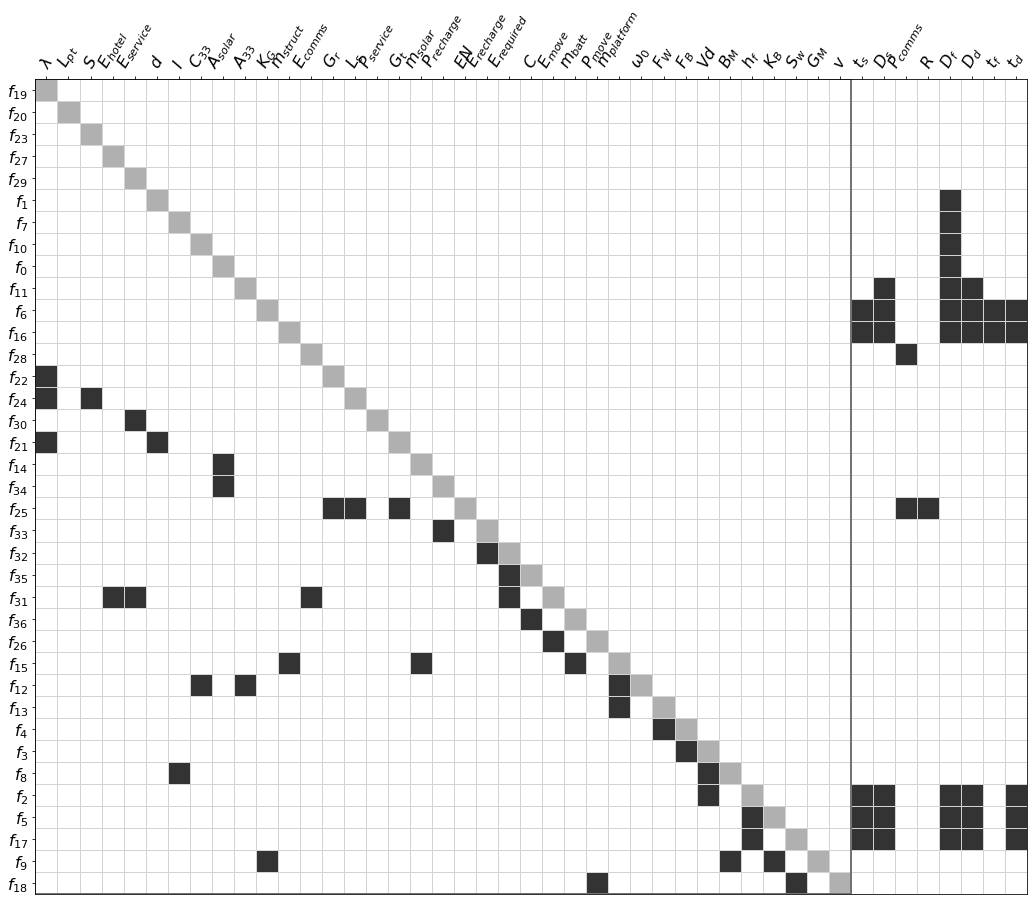

In [67]:
_, ax = render_incidence(edges_minassign_nopar, tree_mina, namingfunc_hsm, figsize=(20,15), figname="pearl_minassign_hsm.png", save=False)

### Make new components

In [68]:
newcomps = transform_components(edges, edges_minassign, model.components, model.idmapping)

In [138]:
newcomps

[(('D_f', '\\alpha'), 0, ('A_{solar}',), '-0.785398163397448*\\alpha*D_f**2 + 0.785398163397448*D_f**2'),
 (('t_s', 'D_d', 'D_f', 't_d', 'D_s', 'Vd'), 2, ('h_f',), '-D_d**2*t_d/D_f**2 - D_s**2*t_s/D_f**2 + 4*Vd/(pi*D_f**2)'),
 (('\\rho_w', 'F_B', 'g'), 3, ('Vd',), 'F_B/(\\rho_w*g)'),
 (('F_W',), 4, ('F_B',), 'F_W'),
 (('m_{platform}', 'g'), 13, ('F_W',), 'g*m_{platform}'),
 (('m_{batt}', 'm_{solar}', 'm_{comms}', 'm_{prop}', 'm_{struct}'), 15, ('m_{platform}',), 'm_{comms} + m_{prop} + m_{batt} + m_{solar} + m_{struct}'),
 (('\\rho_h', '\\rho', 'D_s', 't_f', 't_s', 'D_d', 'D_f', 't_d'), 16, ('m_{struct}',), '\\rho*pi*D_f**2*t_f/4 + \\rho*pi*D_s**2*t_s/4 + \\rho_h*pi*D_d**2*t_d/4'),
 (('\\rho_w', 'P_{move}', '\\eta_m', 'C_d', 'S_w'), 18, ('v',), '2**(1/3)*(\\eta_m*P_{move}/(C_d*\\rho_w*S_w))**(1/3)'),
 (('k', 'R', 'L_s', 'T_s', 'G_r', 'L_a', 'G_t', 'L_p', 'P_{comms}', 'L_l'), 25, ('EN',), 'L_a*L_l*L_p*G_r*G_t*L_s*P_{comms}/(T_s*k*R)'),
 (('E_{move}', 't_{move}'), 26, ('P_{move}',), 'E_{

In [92]:
model.components[17]

(('t_s', 'D_d', 'D_f', 't_d', 'h_f', 'D_s'), 17, ('S_w',), 'pi*D_s*t_s + pi*(D_d**2/2 + D_d*t_d - D_s**2/4) + pi*(D_f**2/4 + D_f*h_f - D_s**2/4)')

## Optimization

In [70]:
#opt = SolverRef('opt', model, 'opt')
addobj(m, mtot) # for optimization make sure to add OPT in model
addineq(m, hf-0.9*tf)
addineq(m, Ds-0.9*Df)
addineq(m, Ds-0.9*Dd)
addineq(m, 0.1-P_move)

In [152]:
solvefor = [tf, ts, td, Ds, Dd, Df]#, Pcomms]

In [94]:
addineq(m, Ds-0.9*Dd)

In [153]:
varoptions = {tf:[0.1,10], ts:[0.1,10], td:[0.1,10], Ds:[0.1,10], Dd:[0.1,10], Df:[0.1,10]}# Pcomms:[10,100]}

In [114]:
Ein,Eout,Rin = edges_minassign
Ein.update({37: ('m_{platform}',), 38: ('t_f','h_f'), 39: ('D_s','D_f'), 40: ('P_{move}',), 41:('D_s','D_d')}) 
Eout.update({37: (None,), 38: (None,), 39: (None,), 40:(None,), 41:(None,)})

In [115]:
Ftree = tree_mina[0]
Ftree[37] = 'root'
Ftree[38] = 'root'
Ftree[39] = 'root'
Ftree[40] = 'root'
Ftree[41] = 'root'

In [154]:
tree_mina_opt = (tree_mina[0], {}, {elt.varid:'root' for elt in solvefor})
model.var_options = {elt.varid:var for elt,var in varoptions.items()}

In [155]:
model.solvers_options['root'] = {'type': OPT, 'disp':True, 'optimizer': 'SLSQP', 'maxiter':200}

In [156]:
comp_options = model.comp_options
var_options = model.var_options
solvers_options = model.solvers_options
components = model.components
idmapping = model.idmapping # map from str to Var
nodetyperepr = model.nametyperepr
sequence = order_from_tree(tree_mina_opt[0], tree_mina_opt[1], edges_minassign[1])
solvers_options = default_solver_options(tree_mina_opt, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [173]:
prob, mdao_in, groups, namingfunc = model_to_problem(model, formulation=(edges_minassign, tree_mina_opt), components=model.components+newcomps)

In [207]:
prob.set_val('alpha', 0.2)
prob.set_val('t_f',0.15)
prob.set_val('t_s',0.2)
prob.set_val('t_d',0.2)
prob.set_val('D_f', 3.713)
prob.set_val('D_s', 0.1)
prob.set_val('D_d', 1.)
prob.set_val('P_comms', 50)

In [208]:
prob.run_model()

In [215]:
prob.list_problem_vars(cons_opts=['lower', 'upper', 'equals'])

----------------
Design Variables
----------------
name  val           size  
----  ------------  ---- 
t_f   [0.1]         1     
t_s   [9.99999996]  1     
t_d   [0.1]         1     
D_s   [0.19207769]  1     
D_d   [0.21342215]  1     
D_f   [1.98479459]  1     

-----------
Constraints
-----------
name   val                size  lower   upper  equals  
-----  -----------------  ----  ------  -----  ------ 
neq38  [1.75100872e-07]   1     -1e+30  0.0    None    
neq39  [-1.59423743]      1     -1e+30  0.0    None    
neq40  [-0.00046021]      1     -1e+30  0.0    None    
neq41  [-2.23981989e-06]  1     -1e+30  0.0    None    

----------
Objectives
----------
name   val             size  
-----  --------------  ---- 
obj37  [585.29647451]  1     



In [210]:
prob.run_driver()

Optimization terminated successfully    (Exit mode 0)
            Current function value: [585.29647451]
            Iterations: 13
            Function evaluations: 23
            Gradient evaluations: 11
Optimization Complete
-----------------------------------


False

In [212]:
from math import log10

In [214]:
10*log10(prob.get_val('EN'))

14.182093183444241

In [217]:
prob.get_val('h_f')

array([0.09000018])

In [133]:
prob.run_model()

In [134]:
print_inputs(model, prob, namingfunc, mdao_in, filterparam=True)

$$D_s$$,0.203,m
$$t_f$$,0.1,m
$$t_d$$,0.1,m
$$t_s$$,10,m
$$P_{comms}$$,87.312,W
$$R$$,10,Mbit/s
$$D_f$$,1.832,m
$$D_d$$,0.226,m


In [216]:
print_outputs(model, prob, namingfunc)

$$D_f$$,1.985,m
$$d$$,0.397,m
$$Vd$$,0.572,m³
$$F_B$$,5741.758,N
$$F_W$$,5741.758,kg·m/s²
$$K_B$$,5.474,m
$$K_G$$,5.518,m
$$I$$,0.762,m⁴
$$B_M$$,1.332,m
$$G_M$$,1.288,m
$$C_{33}$$,3.107×10⁴,kg/s²


# Solve

In [41]:
addobj(model.root, mtot) # for optimization make sure to add OPT in model
addineq(model.root, -td+0.1)
setsolvefor(model.root, [tf, Ds], {tf:[0,10], Ds:[0,10]})
edges, tree = model.generate_formulation()

In [43]:
ordered_tree = tree
ordered_edges = edges

In [46]:
nodetyperepr = model.nametyperepr
nodetyperepr[SOLVER] = '{}'
namingfunc = namefromsympy(nodetyperepr)

In [47]:
components = model.components
lookup_f = get_f(components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)

In [48]:
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc, model.idmapping)

In [49]:
prob.set_solver_print(level=0)
#prob.set_solver_print(level=1, depth=1)
prob.setup();

In [49]:
# prob.set_val('t_f', 0.5)
# prob.set_val('h_f', 0.45)
# prob.set_val('D_s', 0.5)

In [50]:
prob.run_driver()

NL: NewtonSolver 'NL: Newton' on system 'mdf' failed to converge in 20 iterations.
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: [377.09111883]
            Iterations: 13
            Function evaluations: 41
            Gradient evaluations: 9
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------


True

In [ ]:
prob.set_val('t_f', 0.5)
prob.set_val('h_f', 0.45)

In [50]:
prob.run_model()

In [54]:
#print_inputs(model, prob, namingfunc, mdao_in, filterparam=False)

# Results

In [52]:
print_outputs(model, prob, namingfunc)

$$d$$,1.419,m
$$D_f$$,2.837,m
$$Vd$$,0.368,m³
$$F_B$$,3699.264,N
$$F_W$$,3699.264,kg·m/s²
$$K_B$$,-2.244e+00,m
$$K_G$$,4.201,m
$$I$$,3.18,m⁴
$$B_M$$,8.632,m
$$G_M$$,2.187,m
$$C_{33}$$,6.348×10⁴,kg/s²
